# Project Description
// write something here

### Brief Steps
1. Use segmentation model to segment rices in the image.
2. Use watershed algorithm to improve the segmentation results.
3. Find the ratio between Jasmine and Non-Jasmine rices.
4. Find the ratio between widht and height of each rice.
5. Find the germ quality of each rice.
5. Rate each rice based on width-height ratio and germ quality.
6. Calculate overall score of group of rices based on the rating from step 5 and jasmine ratio.

# Create new Conda environment (optional)
You can run with the following command in your conda terminal:
```bash
!conda env create -f environments.yaml
```
Or run the following cell to create a new conda environment.

In [2]:
# uncomment the following line to install the environment
# !conda env create -f environments.yaml
# !conda activate cv_term_project

In [3]:
# or install the required packages manually
# !pip install requirements.txt

# Import Libraries


In [4]:
import os
import sys
import shutil
import cv2
import numpy as np
import gdown
from ultralytics import YOLO
import matplotlib.pyplot as plt
from pathlib import Path
import random
import pandas as pd

In [5]:
# set random seed
random.seed(42)

# Load testing images

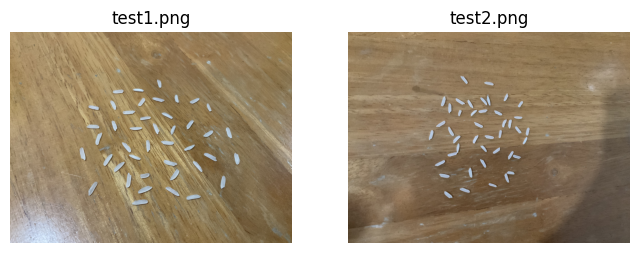

In [6]:
test_image_path = './test'
test_images = os.listdir(test_image_path)
test_images = [os.path.join(test_image_path, img) for img in test_images]

num_of_test_img = len(test_images)

# pick 25 random images from the test set
picked_images = np.random.choice(test_images, min(25, num_of_test_img), replace=False)

# define figure size
num_of_col = min(5, num_of_test_img)
num_of_row = int(np.ceil(num_of_test_img / num_of_col))
fig, axs = plt.subplots(num_of_row, num_of_col, figsize=(4*num_of_col, 5*num_of_row))

for i, image_path in enumerate(picked_images):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    if num_of_row > 1:
        ax = axs[i // num_of_col, i % num_of_col]
    else:
        ax = axs[i % num_of_col]
        
    ax.imshow(image)
    ax.title.set_text(os.path.basename(image_path))
    ax.axis('off')
plt.show()

# Load models from Google Drive

In [7]:
Path("models").mkdir(parents=True, exist_ok=True)

In [7]:
%%script False
# old seg-model (40 epochs, 800 imgsz)
# !gdown 1XAhWz2LepRqSSsCKD2tMY0nlSI8me6TY -O ./models/seg-model.onnx

# new seg-model (150 epochs, 1440 imgsz)
!gdown 1lB8lhWyuUWVZ3YLuzhFm0uUQrrkditWe -O ./models/seg-model.onnx

# old rice-germ-cls-model
# !gdown 1jEC3CKjIo5vtm3qGAW2lVlP1fZsE7Lpp -O ./models/rice-germ-cls-model.onnx

# new rice-germ-cls-model
!gdown 1LwKwyoAwR_esRkkv2mG4Ej-_PZYsl6rr -O ./models/rice-germ-cls-model.onnx

Downloading...
From (original): https://drive.google.com/uc?id=1lB8lhWyuUWVZ3YLuzhFm0uUQrrkditWe
From (redirected): https://drive.google.com/uc?id=1lB8lhWyuUWVZ3YLuzhFm0uUQrrkditWe&confirm=t&uuid=d1f1b013-79b6-4eb6-a4c3-835028b4b672
To: c:\Users\chant\Desktop\CV_Project\ComputerVision_STA_Project\models\seg-model.onnx

  0%|          | 0.00/288M [00:00<?, ?B/s]
  0%|          | 524k/288M [00:00<01:17, 3.69MB/s]
  1%|          | 3.15M/288M [00:00<00:19, 14.7MB/s]
  3%|▎         | 8.39M/288M [00:00<00:09, 30.1MB/s]
  6%|▌         | 16.3M/288M [00:00<00:05, 45.8MB/s]
  7%|▋         | 21.0M/288M [00:00<00:06, 41.1MB/s]
  9%|▉         | 25.7M/288M [00:00<00:06, 37.9MB/s]
 10%|█         | 29.9M/288M [00:00<00:08, 31.9MB/s]
 12%|█▏        | 33.6M/288M [00:01<00:10, 24.8MB/s]
 13%|█▎        | 36.7M/288M [00:01<00:11, 21.6MB/s]
 14%|█▎        | 39.3M/288M [00:01<00:11, 21.1MB/s]
 15%|█▍        | 41.9M/288M [00:01<00:12, 20.0MB/s]
 15%|█▌        | 44.6M/288M [00:01<00:12, 19.2MB/s]
 16%|█▌      

# Main application

## Create a directory for saving the results

In [8]:
import datetime
time = datetime.datetime.now().strftime("%y%m%d%H%M")
save_dir = f"./output/run-{time}"
Path(save_dir).mkdir(parents=True, exist_ok=True)

## Segment rices from the image

In [9]:
# load the segmentation model
seg_model = YOLO('./models/seg-model.onnx', task='segment')

In [10]:
# do not change imgsz, but you can try different values for conf
# imgsz = 800 # for old model
imgsz = 1440 # for new model
seg_results = seg_model.predict(source=test_image_path, imgsz=imgsz, device="0", conf=0.5)

Loading models/seg-model.onnx for ONNX Runtime inference...
requirements: Ultralytics requirement ['onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.1/192.1 MB 7.1 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 12.8 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 36.4s, installed 1 package: ['onnxruntime-gpu']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


image 1/2 /home/andre/Desktop/ComputerVision_STA_Project/test/test1.png: 1440x1440 43 {0: 'Jasmine'}s, 78.2ms
image 2/2 /home/andre/Desktop/ComputerVision_STA_Project/test/test2.png: 1440x1440 43 {0: 'Jasmine'}s, 70.9ms
Speed: 12.9ms preprocess, 74.6ms inference, 95.9ms postprocess per image at shape (1, 3, 1440, 1440)


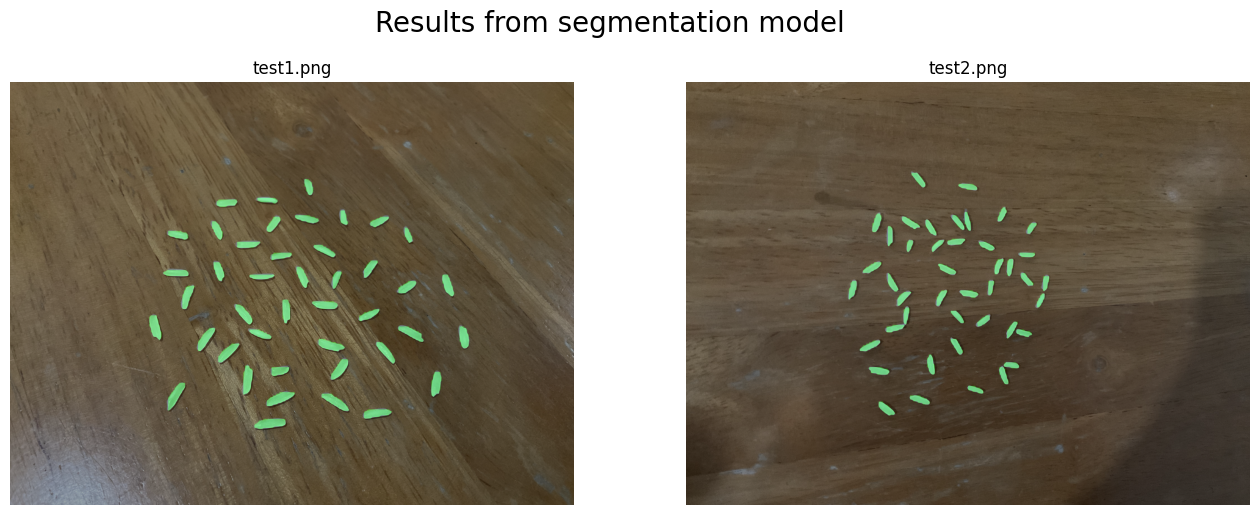

In [11]:
# visualize the some results from prediction
colors = {
    0: (0, 255, 0), # Green mask for Jasmine rice
    1: (255, 0, 0), # Red mask for Non-jasmine rice
}

def display_seg_result(results, max_display=25, save=False):
    if len(results) > max_display:
        results = results[:max_display]
    
    # define figure size
    num_of_results = len(results)
    num_of_col = min(3, num_of_results)
    num_of_row = int(np.ceil(num_of_results / num_of_col))
    fig, axs = plt.subplots(num_of_row, num_of_col, figsize=(8*num_of_col, 8*num_of_row))
    
    for i, result in enumerate(results):
        base_image = result.orig_img
        base_image = cv2.cvtColor(base_image, cv2.COLOR_BGR2RGB)

        labels = result.boxes.cls.cpu().numpy()
        xy = result.masks.xy
        
        # draw masks of the detected objects (iterate over xy)
        blank_image = np.zeros_like(base_image)
        for mask, label in zip(xy, labels):
            mask = mask.reshape((-1, 1, 2))
            mask = mask.astype(np.int32)
            cv2.fillPoly(blank_image, [mask], colors[int(label)])
        
        alpha = 0.35
        cv2.addWeighted(blank_image, alpha, base_image, 1 - alpha, 0, base_image)
        
        if num_of_row > 1:
            ax = axs[i // num_of_col, i % num_of_col]
        else:
            ax = axs[i % num_of_col]
            
        ax.imshow(base_image)
        ax.axis('off')
        ax.title.set_text(os.path.basename(result.path))
    
    fig.suptitle("Results from segmentation model", fontsize=20, y=0.85)
    plt.show()
    
    # save the figure
    if save:
        fig.savefig(f"{save_dir}/seg-results{num_of_results}.png")
    
display_seg_result(seg_results)

# Apply traditional computer vision techniques to improve segmentation
Since the segmentation model is not perfect, we will use watershed algorithm to improve the segmentation.

In [12]:
def improve_result(result, imshow=False, save=False):
    base_image = result.orig_img
    # base_image = cv2.cvtColor(base_image, cv2.COLOR_BGR2RGB)

    labels = result.boxes.cls.cpu().numpy()
    xy = result.masks.xy
    
    items = [item for item in zip(xy, labels) if item[1] == 0] # filter out non-jasmine rice
    
    # create blank image with the same shape as the base image but with only one channel
    blank_image = np.zeros((base_image.shape[0], base_image.shape[1]), dtype=np.uint8)
    for mask, label in items:
        mask = mask.astype(np.int32)
        cv2.fillPoly(blank_image, [mask], 255)
    
    # apply distance transform to the blank_image
    distanceTransformOutput = cv2.distanceTransform(blank_image,cv2.DIST_L2, 3)
    maxDistance = np.max(distanceTransformOutput)
    roughMarkerPixel = np.uint8(distanceTransformOutput > 0.35 * maxDistance)
    
    # generate seeds
    _, seed = cv2.connectedComponents(roughMarkerPixel)
    
    # finding unknown region
    dilate_blanks = cv2.dilate(blank_image, np.ones((5,5),np.uint8), iterations = 10)

    thresholdCoinImageCopy = np.uint8(dilate_blanks/255)
    unknownRegion = np.uint8(thresholdCoinImageCopy - roughMarkerPixel)
    newSeed = seed.copy()
    newSeed += 1
    newSeed[unknownRegion==1] = 0
    
    # apply watershed algorithm
    outputImage = base_image.copy()
    outputMarkers = cv2.watershed(outputImage,newSeed) ### Warning seed will get modified here!!

    if imshow or save:
        # 1 is background, -1 is border
        for outputMarkerIdx in range(2,np.max(outputMarkers+1)):
            color = (0, 255, 0)
            # draw with opacity = 50%
            outputImage[np.where(outputMarkers == outputMarkerIdx)] = (outputImage[np.where(outputMarkers == outputMarkerIdx)] * 0.5 + np.array(color) * 0.5).astype(np.uint8)
                
        if save:
            file_name = os.path.basename(result.path).split('.')[0]
            Path(f"{save_dir}/{file_name}").mkdir(parents=True, exist_ok=True)
            cv2.imwrite(f"{save_dir}/{file_name}/watershed-result.jpg", outputImage)
                    
        if imshow:
            outputImage = cv2.cvtColor(outputImage,cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(10,10))
            plt.axis('off')
            plt.title("Watershed Result of \"{}\"".format(os.path.basename(result.path)))
            plt.imshow(outputImage)
            plt.show()
    
    return outputMarkers

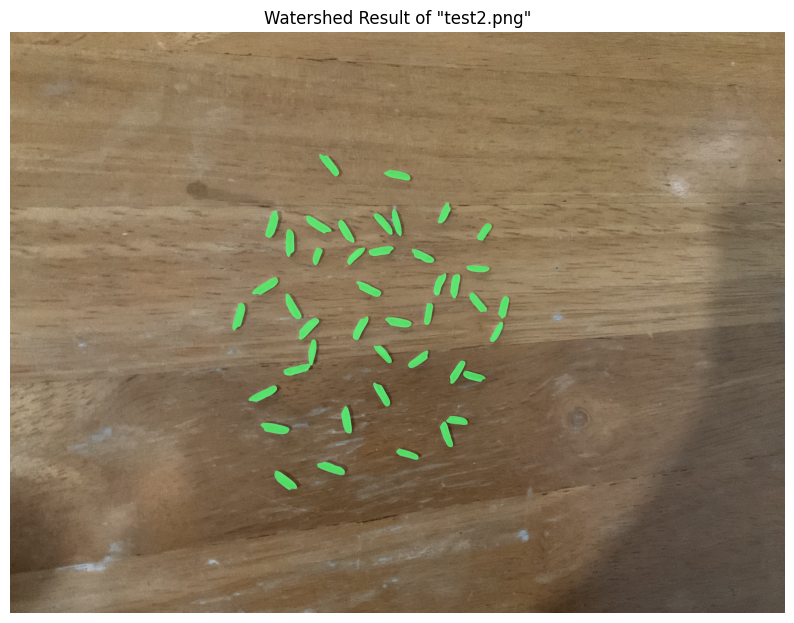

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1,  1,  1, ...,  1,  1, -1],
       [-1,  1,  1, ...,  1,  1, -1],
       ...,
       [-1,  1,  1, ...,  1,  1, -1],
       [-1,  1,  1, ...,  1,  1, -1],
       [-1, -1, -1, ..., -1, -1, -1]], dtype=int32)

In [13]:
# test the function
improve_result(seg_results[1], imshow=True, save=False)

## Calculate rating of each rice and overall rating of image
- Use the results from watershed algorithm to segment rices.
- Calculate the ratio of width and height of each rice.
- Use classification model to classify the quality of rice germ.

In [14]:
rice_germ_model = YOLO('./models/rice-germ-cls-model.onnx', task='classify')

### The cell below may look a bit complex, think of it as a M A G I C

In [20]:

from scipy.spatial import ConvexHull

# main function to process the rating, the input is the result from the segmentation model
def processResult(result, imshow=False, save=False):
    labels = result.boxes.cls.cpu().numpy()
    num_of_jasmine = np.sum(labels == 0)
    num_of_non_jasmine = np.sum(labels == 1)
    jasmine_ratio = num_of_jasmine / (num_of_jasmine + num_of_non_jasmine)
    
    outputMarkers = improve_result(result, imshow=imshow, save=save)
    
    germ_results = []
    lw_ratios = []
    probs = []
    ratings = []
    for i in range(2,np.max(outputMarkers)+1):
        mask = np.zeros_like(outputMarkers, dtype=np.uint8)
        mask[outputMarkers == i] = 255
        riceImg = result.orig_img
        
        # crop the riceImg with square bounding box
        contour, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        x,y,w,h = cv2.boundingRect(contour[0])
        riceImg = riceImg[y:y+h, x:x+w]
        mask = mask[y:y+h, x:x+w]
        
        # openning operation to remove small noise
        kernel = np.ones((7,7), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)
        
        # apply mask to the original image
        riceImg = cv2.bitwise_and(riceImg, riceImg, mask=mask)
        
        # create a black image 128x128 and paste the resized riceImg in the center (by keeping the aspect ratio of the riceImg)
        blank_image = np.zeros((128, 128, 3), np.uint8)
        h, w = riceImg.shape[:2]
        r = 96 / max(h, w)
        h, w = int(h * r), int(w * r)
        riceImg = cv2.resize(riceImg, (w, h))
        x_offset = (128 - w) // 2
        y_offset = (128 - h) // 2
        blank_image[y_offset:y_offset+h, x_offset:x_offset+w] = riceImg
        
        germ_result = rice_germ_model.predict(blank_image, imgsz=128, conf=0.5, device="0")
        prob = germ_result[0].probs.data.cpu().numpy() # class probs = [Bad, Good, Moderate]
        
        # calculate the ratio of the width and length of the rice grain
        real_width, real_length = findWidthLength(contour)
        lw_ratio = real_length / real_width
        
        lw_ratios.append(lw_ratio)
        probs.append(np.argmax(prob))
        germ_results.append(germ_result)
    
    # calculate jasmine ratio score
    jasmine_ratios = [0.9, 0.8, 0.7, 0.6, 0.5]
    jasmine_scores = [5, 4, 3, 2, 1, 0]
    jasmine_score = next((score for ratio, score in zip(jasmine_ratios, jasmine_scores) if jasmine_ratio > ratio), 0)
    
    # calculate the ratings and overall rating
    for i in range(len(germ_results)):
        ratings.append(calEachRiceRating(lw_ratios[i], probs[i]))
    
    overall_rating = (np.mean(ratings) + jasmine_score) / 2
    
    # define the save path
    file_name = None
    if save or imshow:
        file_name = os.path.basename(result.path).split('.')[0]
        save_path = f"{save_dir}/{file_name}"
        Path(save_path).mkdir(parents=True, exist_ok=True)
    
        # display the results of the process
        displayEachRiceInfo(germ_results, lw_ratios, ratings, imshow=imshow, save=save, file_name=file_name)
        
    return overall_rating, jasmine_ratio

# find width and length of a rice grain (use convex hull and rotatation)
def findWidthLength(contour):
    points = contour[0].reshape(-1, 2)
    
    hull = ConvexHull(points)
    hull_points = points[hull.vertices]

    angles = np.arange(0, 360, 1)
    wls = []

    for angle in angles:
        angle_rad = np.deg2rad(angle)
        rotation_matrix = np.array([[np.cos(angle_rad), -np.sin(angle_rad)], [np.sin(angle_rad), np.cos(angle_rad)]])
        rotated_points = np.dot(hull_points, rotation_matrix)
        min_x, max_x = np.min(rotated_points[:, 0]), np.max(rotated_points[:, 0])
        min_y, max_y = np.min(rotated_points[:, 1]), np.max(rotated_points[:, 1])
        width = min(max_x - min_x, max_y - min_y)
        length = max(max_x - min_x, max_y - min_y)
        wls.append((width, length))

    # find the longest length
    real_width, real_length = max(wls, key=lambda x: x[1])

    return real_width, real_length

# for calculating the rating of a rice grain
def calEachRiceRating(lw_ratio, prob):    
    # calculate germ score
    germ_scores = {0: 0, 1: 2, 2: 1} # {Bad: 0, Good: 2, Moderate: 1}
    germ_score = germ_scores[prob]
    
    # calculate ratio score
    ratios = [3.2443*0.9, 3.2443*0.8, 3.2443*0.7] # from experiment
    ratio_scores = [3, 2, 1, 0]
    ratio_score = next((score for ratio, score in zip(ratios, ratio_scores) if lw_ratio > ratio), 0)
        
    return germ_score + ratio_score
    
# for plotting the result from the germ classification model
def displayEachRiceInfo(germ_results, ratios, ratings, imshow=False, save=False, file_name=None):
    num_rice = len(germ_results)
    num_of_col = 5
    num_of_row = int(np.ceil(num_rice / num_of_col))
    fig, axs = plt.subplots(num_of_row, num_of_col, figsize=(20, 40))
    
    for i in range(num_rice):
        germ_result = germ_results[i]
        probs = germ_result[0].probs.data.cpu().numpy() # probs {0: Bad, 1: Good, 2: Moderate}
        
        # display the result with probability text on the image
        ax = axs[i // num_of_col, i % num_of_col]
        ax.imshow(cv2.cvtColor(germ_result[0].orig_img, cv2.COLOR_BGR2RGB))
        ax.axis('off')
        
        max_prob = np.argmax(probs)
        quality = ['Bad', 'Good', 'Moderate'][max_prob]
        
        ax.text(5, 10, f"Germ {quality} prob: {probs[max_prob]:.2f}", color='white', fontsize=8, backgroundcolor='blue')
        ax.text(5, 20, f"L/W Ratio: {ratios[i]:.4f}", color='white', fontsize=8, backgroundcolor='blue')
        ax.text(5, 30, f"Rating: {ratings[i]}", color='white', fontsize=8, backgroundcolor='blue')
    
    fig.suptitle(f"Information of each rice of \"{file_name}\"", fontsize=30, y=0.9)
    
    if save:
        fig.savefig(f"{save_dir}/{file_name}/each-rice-info.jpg")
        print("saved at", f"{save_dir}/{file_name}/each-rice-info.jpg")
    
    if imshow:
        plt.show()
    else:
        plt.close(fig)


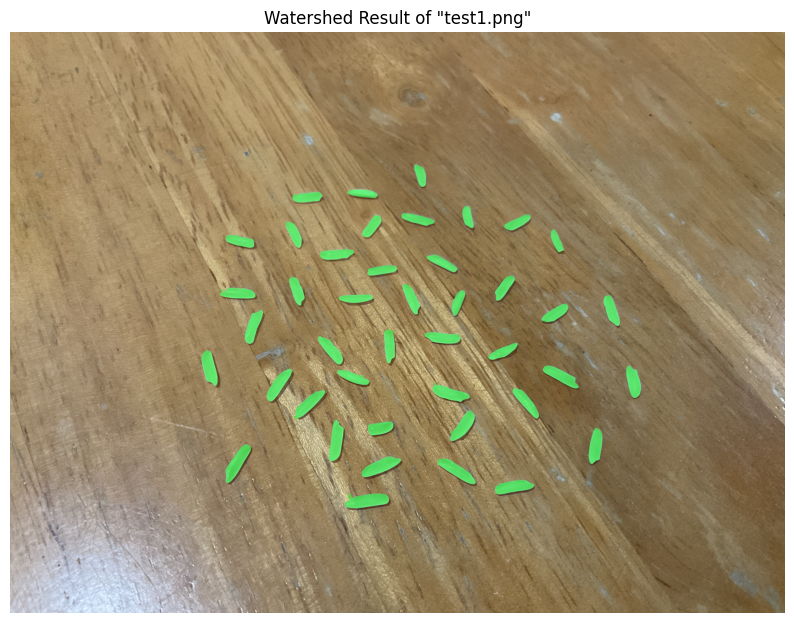


0: 128x128 Good 0.52, Moderate 0.44, Bad 0.04, 3.0ms
Speed: 0.7ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 Good 0.50, Moderate 0.30, Bad 0.19, 3.0ms
Speed: 0.8ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 Moderate 0.93, Bad 0.07, Good 0.00, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 Moderate 1.00, Bad 0.00, Good 0.00, 3.0ms
Speed: 0.7ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 Bad 0.97, Moderate 0.03, Good 0.00, 3.6ms
Speed: 0.7ms preprocess, 3.6ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 Moderate 1.00, Good 0.00, Bad 0.00, 3.8ms
Speed: 1.2ms preprocess, 3.8ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 Moderate 0.99, Bad 0.01, Good 0.00, 3.5ms
Speed: 0.6ms preprocess, 3.5ms inference, 0.0m

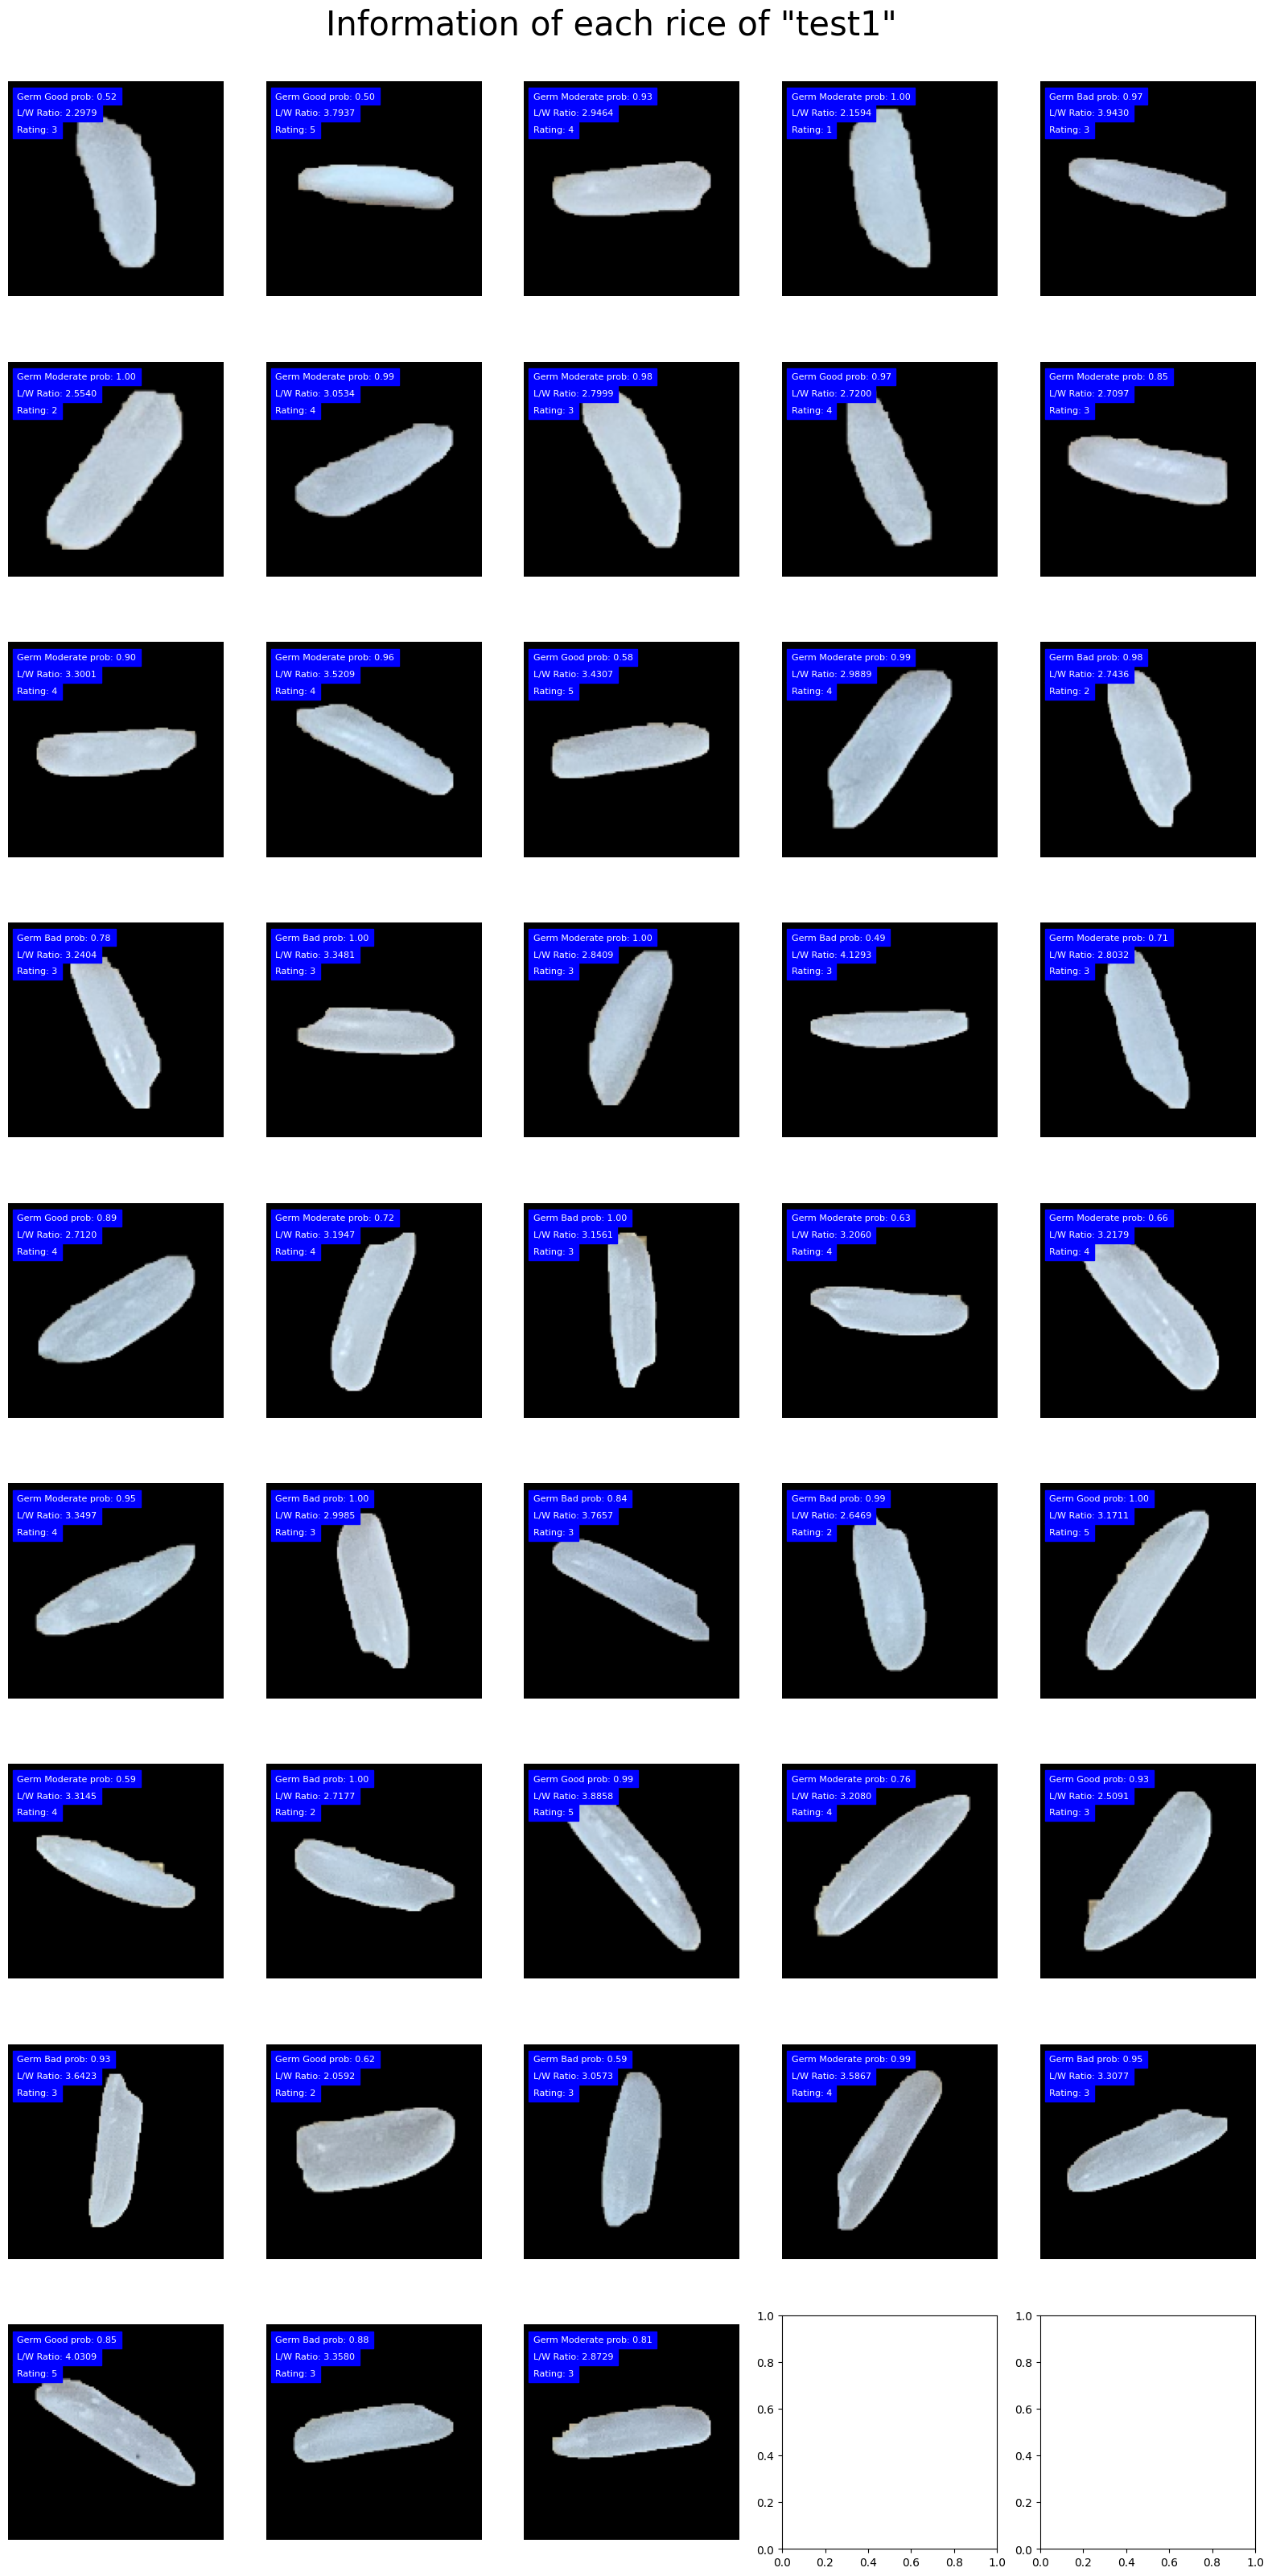

Overall rating: 4.20, Jasmine ratio: 1.00


In [21]:
# test the function
overall_rating, jasmine_ratio = processResult(seg_results[0], imshow=True, save=False)
print(f"Overall rating: {overall_rating:.2f}, Jasmine ratio: {jasmine_ratio:.2f}")

# Calculate rating of all testing images
### Please put rice images that you want to rate in the './test' folder and run the cell below.
### The output will be saved in the './output/run-{timestamp}' folder.

In [17]:
result_rating = []
for result in seg_results:
    overall_rating, jasmine_ratio = processResult(result, imshow=False, save=True)
    file_name = os.path.basename(result.path)
    result_rating.append({"file_name": file_name, "overall_rating": overall_rating, "jasmine_ratio": jasmine_ratio})


0: 128x128 Good 0.52, Moderate 0.44, Bad 0.04, 3.1ms
Speed: 1.4ms preprocess, 3.1ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 Good 0.50, Moderate 0.30, Bad 0.19, 3.4ms
Speed: 1.0ms preprocess, 3.4ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 Moderate 0.93, Bad 0.07, Good 0.00, 3.1ms
Speed: 0.8ms preprocess, 3.1ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 Moderate 1.00, Bad 0.00, Good 0.00, 3.6ms
Speed: 0.7ms preprocess, 3.6ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 Bad 0.97, Moderate 0.03, Good 0.00, 3.1ms
Speed: 0.7ms preprocess, 3.1ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 Moderate 1.00, Good 0.00, Bad 0.00, 3.6ms
Speed: 1.0ms preprocess, 3.6ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 Moderate 0.99, Bad 0.01, Good 0.00, 3.1ms
Speed: 0.6ms preprocess, 3.1ms inference, 0.0m

In [27]:
df = pd.DataFrame(columns=["file_name", "overall_rating", "jasmine_ratio"])

for i, rating in enumerate(result_rating):
    df.loc[i] = [rating["file_name"], rating["overall_rating"], rating["jasmine_ratio"]]
    print(f"File: {rating['file_name']}, Rating: {rating['overall_rating']}, Jasmine Ratio: {rating['jasmine_ratio']}")
    
df.to_csv(f"{save_dir}/running_result.csv", index=False)

File: test1.png, Rating: 4.220930232558139, Jasmine Ratio: 1.0
File: test2.png, Rating: 4.4186046511627906, Jasmine Ratio: 1.0
